# Práctica 2: Determinación de Tipos de Estrellas
Autores: Rodrigo Maroto Caño y Rodrigo Toldos Frutos  
Correos electrónicos: 100454455@alumnos.uc3m.es - 100454470@alumnos.uc3m.es   
Usuarios en GitHub: @RodrigoMaroto (owner) y @100454470   
Link del repositorio: https://github.com/RodrigoMaroto/Practica2-ML/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.pipeline import Pipeline

np.random.seed(454455)

/tmp/ipykernel_37591/3130104804.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/rodrx/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Implementación de K-means

In [35]:
def kmeans(X, n_clusters=2, max_iters=100):
        centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
        for _ in range(max_iters):
            distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
            labels = np.argmin(distances, axis=0)

            new_centroids = np.empty_like(centroids)
            for i in range(n_clusters):
                new_centroids[i] = X[labels == i].mean(axis=0)
            
            if np.allclose(new_centroids, centroids):
                break
            centroids = new_centroids
        return labels

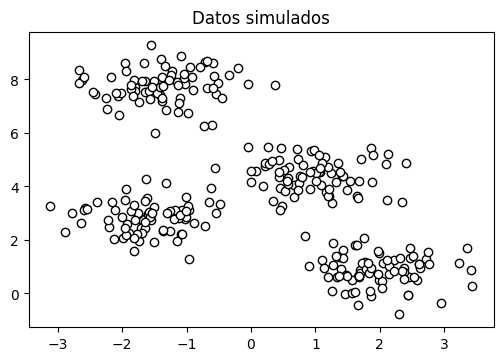

In [36]:
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados');

In [37]:
X_scaled = scale(X)

In [38]:
%%timeit
y_predict = kmeans(X_scaled, 4)


1.31 ms ± 70.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [39]:
modelo_kmeans = KMeans(n_clusters=4, n_init=25, random_state=42)
modelo_kmeans.fit(X=X_scaled)

KMeans(n_clusters=4, n_init=25, random_state=42)

In [40]:
%%timeit
y_predict = modelo_kmeans.predict(X=X_scaled)

187 µs ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [41]:
y_predict = kmeans(X_scaled, 4)

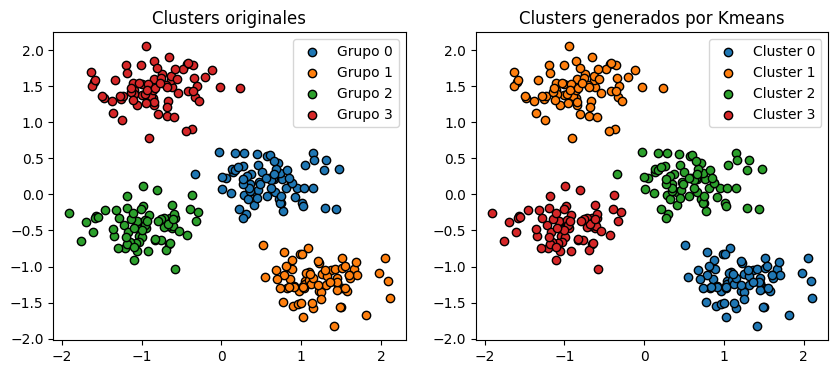

In [42]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();

## 2. Codificación de variables

lectura de datos

In [43]:
df = pd.read_csv("stars_data.csv")


### Primera Opción: OneHotEncoding

In [44]:
# Vamos a utilizar el OneHotEncoder de scikit para las variables categóricas. Ponemos sparse_output = False para que se guarden los valores
# que son 0 también.

enc = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).set_output(transform = 'pandas')
new_col_color = enc.fit_transform(df[['Color']])
new_col_sc = enc.fit_transform(df[['Spectral_Class']])

X_ohe = pd.concat([df, new_col_color, new_col_sc], axis = 1)
X_ohe.drop(columns = ['Color', 'Spectral_Class'], inplace = True)
features = X_ohe.columns


In [45]:
X_ohe = scale(X_ohe)

pca = PCA(n_components=2)
X_ohe_pca = pca.fit_transform(X_ohe)

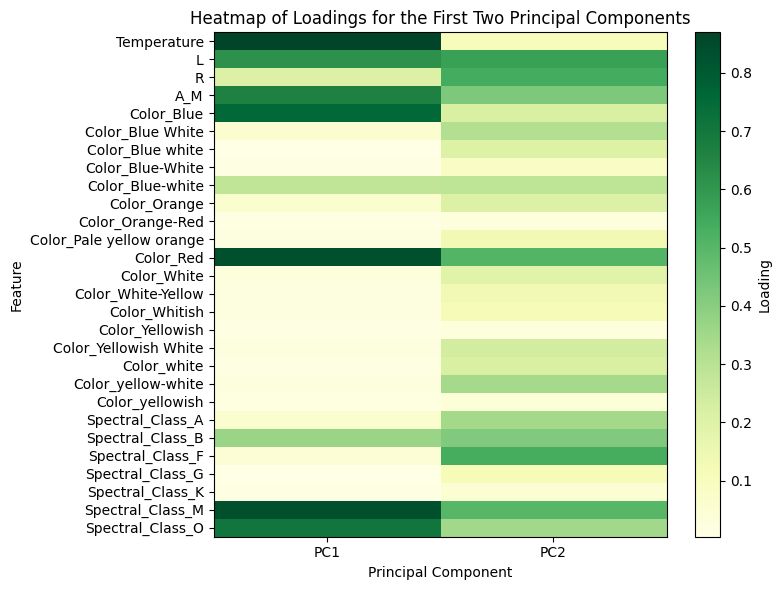

In [46]:
loadings = np.abs(pca.components_[:2].T * np.sqrt(pca.explained_variance_[:2]))

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index= features)

# Plot heatmap of loadings
plt.figure(figsize=(8, 6))
plt.title('Heatmap of Loadings for the First Two Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Feature')
plt.imshow(loadings_df, cmap='YlGn', aspect='auto')
plt.colorbar(label='Loading')
plt.xticks(ticks=np.arange(len(loadings_df.columns)), labels=loadings_df.columns)
plt.yticks(ticks=np.arange(len(loadings_df.index)), labels=loadings_df.index)
plt.tight_layout()
plt.show()

### Segunda Opción: Variable Ordinal

Como se indica en el enunciado, el color está asociado a la cantidad de energía, y algo parecido sucede con la clase espectral. Por tanto, puede tener sentido utilizar estas variables como ordinales, con el fin de representar una cercanía mayor entre dos cantidades de energía parecidas. Con OneHotEncoding no conservamos estas relaciones, ya que se utilizan como columnas independientes. Como se puede ver en la imagen, podemos establecer un orden atendiendo a la temperatura.


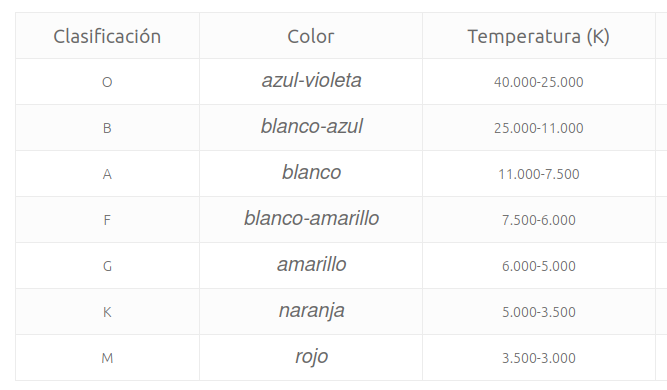

In [47]:
# Primero vamos a ver qué colores hay 
#print(df['Color'].unique())

#['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
#'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
#'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
#'Blue-White']

# Creamos un diccionario para sustituir esos nombres por valores que representen el orden

color_values = {"Red": 1, "Orange-Red": 2, "Orange": 3, "Pale yellow orange": 4, "yellowish": 5, "Yellowish": 5, "White-Yellow": 6,
                "yellow-white": 6,"Yellowish White": 6,"White": 7, "white": 7, "Whitish": 7, "Blue white": 8,"Blue White": 8,  
                "Blue-white": 8, "Blue-White": 8, "Blue": 9,
                }

df['Color'] = df['Color'].map(color_values)

# Hacemos lo mismo con la clase espectral

#print(df['Spectral_Class'].unique())
# ['M' 'B' 'A' 'F' 'O' 'K' 'G']

sc_values = {"M": 1, "K": 2, "G":3, "F":4, "A":5, "B":6, "O":7}
df['Spectral_Class'] = df['Spectral_Class'].map(sc_values)
features = df.columns


In [48]:
X_ord = scale(df)

pca = PCA(n_components=2)
X_ord_pca = pca.fit_transform(X_ord)

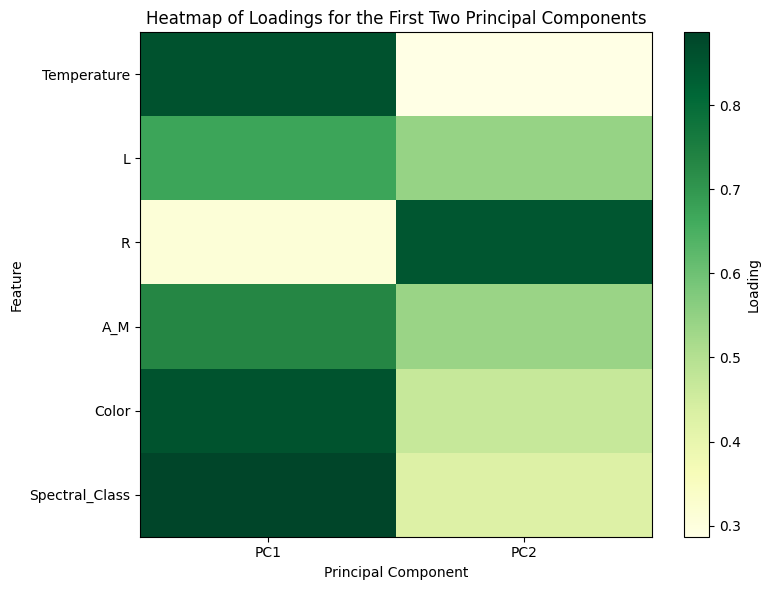

In [49]:
loadings = np.abs(pca.components_[:2].T * np.sqrt(pca.explained_variance_[:2]))

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index= features)

# Plot heatmap of loadings
plt.figure(figsize=(8, 6))
plt.title('Heatmap of Loadings for the First Two Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Feature')
plt.imshow(loadings_df, cmap='YlGn', aspect='auto')
plt.colorbar(label='Loading')
plt.xticks(ticks=np.arange(len(loadings_df.columns)), labels=loadings_df.columns)
plt.yticks(ticks=np.arange(len(loadings_df.index)), labels=loadings_df.index)
plt.tight_layout()
plt.show()

## 3. Algoritmos de Clustering

### K-means
En primer lugar, es necesario determinar el número optimo de clústers.

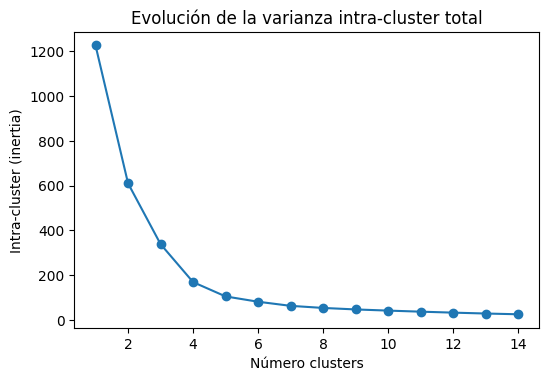

In [50]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(X_ord_pca)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

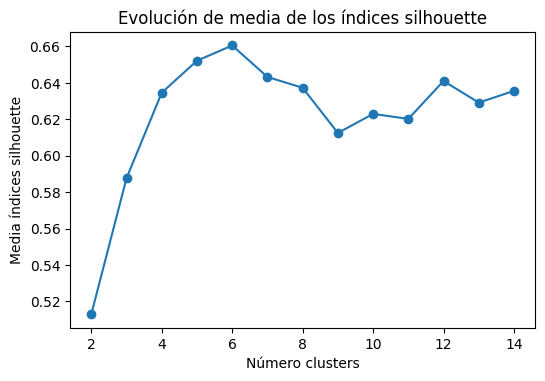

In [51]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_ord_pca)
    silhouette_avg = silhouette_score(X_ord_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [101]:
modelo_kmeans = KMeans(n_clusters=6, random_state=100454455)
y_predict_kmeans = modelo_kmeans.fit_predict(X_ord_pca)

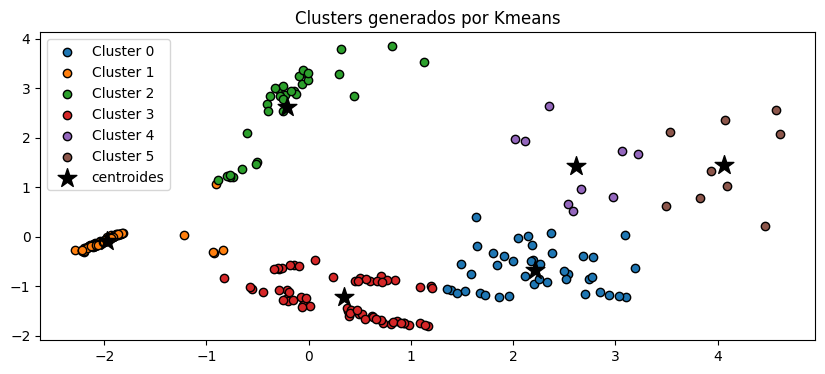

In [102]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 4))


for i in np.unique(y_predict_kmeans):
    ax.scatter(
        x = X_ord_pca[y_predict_kmeans == i, 0],
        y = X_ord_pca[y_predict_kmeans == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

### DBSCAN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


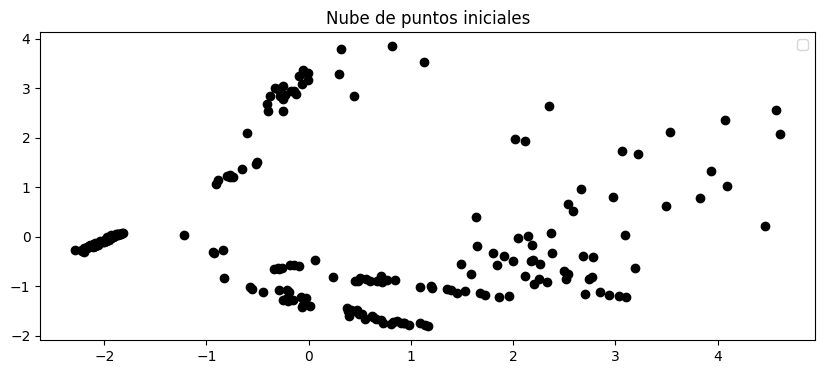

In [54]:
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ord_pca[:, 0],
    y = X_ord_pca[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

Para encontrar un valor óptimo de la variable eps, se puede analizar el silhouette score para distintos valores, de manera que podamos encontrar un valor de eps que maximice la calidad del clustering

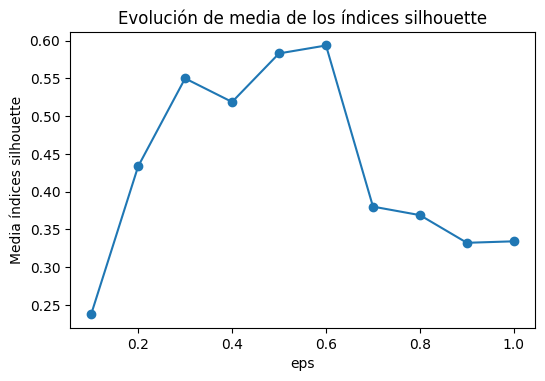

In [83]:
# Método silhouette para identificar el número óptimo de eps
# ==============================================================================
range_eps = np.arange(0.1, 1.1, 0.1)
range_eps = list(range_eps)
valores_medios_silhouette = []

for n_eps in range_eps:
    modelo_dbscan = DBSCAN(
    eps          = n_eps,
    min_samples  = 5,
    metric       = 'euclidean',
    )

    modelo_dbscan.fit(X_ord_pca)
    cluster_labels = modelo_dbscan.fit_predict(X_ord_pca)
    silhouette_avg = silhouette_score(X_ord_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_eps, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('eps')
ax.set_ylabel('Media índices silhouette');

Por otro, lado, podemos proceder de igual manera para encontrar un valor óptimo del parámetro min_samples

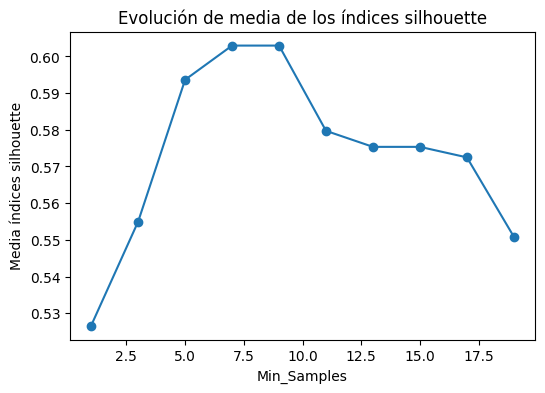

In [94]:
# Método silhouette para identificar el número óptimo de min_samples
# ==============================================================================
range_min_samples = range(1, 20, 2)

valores_medios_silhouette = []

for n_min_samples in range_min_samples:
    modelo_dbscan = DBSCAN(
    eps          = 0.6,
    min_samples  = n_min_samples,
    metric       = 'euclidean',
    )

    modelo_dbscan.fit(X_ord_pca)
    cluster_labels = modelo_dbscan.fit_predict(X_ord_pca)
    silhouette_avg = silhouette_score(X_ord_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range_min_samples, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Min_Samples')
ax.set_ylabel('Media índices silhouette');

In [95]:
modelo_dbscan = DBSCAN(
    eps          = 0.6,
    min_samples  = 7,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X_ord_pca)

DBSCAN(eps=0.6, min_samples=7)

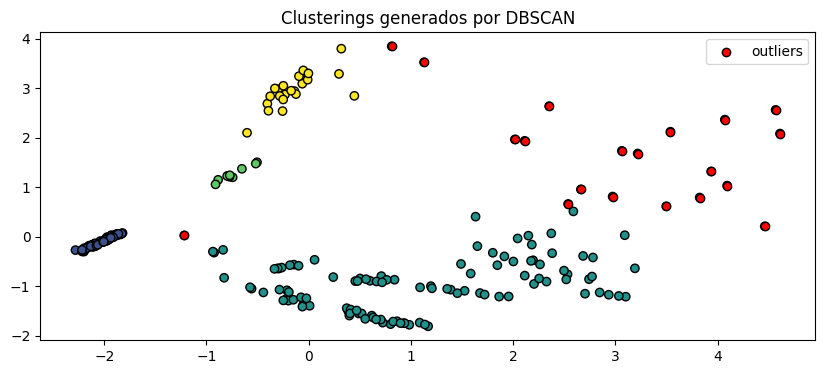

In [96]:
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ord_pca[:, 0],
    y = X_ord_pca[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_ord_pca[labels == -1, 0],
    y = X_ord_pca[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [97]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 4
Número de outliers encontrados: 20


### Comparación de resultados

En primer lugar, el algoritmo de kmeans es capaz de reconocer que el número de clústers óptimo es 6. Con elbow method se puede ver que el número de clústers es cercano a 6, mientras que si se utiliza el método de silhouette se puede ver claramente que el número de conjuntos que maximiza la calidad del clustering es 6. Por otro lado, el método DBSCAN, utilizando el método silhouette, determina que el número óptimo de clústers es 4. Como se sabe que el número de clústers es 6, se puede concluir que en este caso el método de kmeans es capaz de detectar mejor el número de grupos que hay en un conjunto de datos que DBSCAN. 

Por otro lado, el método de kmeans asigna a todos los elementos un clúster, mientras que DBSCAN deja 20 elementos sin clasificar (outliers).

Además, podemos comparar los valores de silueta de ambos métodos:

In [98]:
cluster_labels = modelo_dbscan.fit_predict(X_ord_pca)
silhouette_avg = silhouette_score(X_ord_pca, cluster_labels)
silhouette_avg

0.6029367567602255

In [99]:
cluster_labels = modelo_kmeans.fit_predict(X_ord_pca)
silhouette_avg = silhouette_score(X_ord_pca, cluster_labels)
silhouette_avg

0.6345936166691188

Para el método DBSCAN se ha obtenido un valor medio de silueta de 0.603, mientras que para kmeans se ha obtenido un valor medio de 0.634. Este valor representa cuán parecido es un valor al clúster que se le ha asignado comparado con los otros clústeres. Por tanto un valor más alto en esta métrica indica una mayor afinidad de un elemento con el clúster al que ha sido asignado. En nuestro caso, hemos obtenido un valor mejor para kmeans, lo que nos indica una mayor calidad del clustering.

Por otro lado, podemos fijarnos en otras métricas para analizar en mayor profundidad ambos métodos. Por ejemplo, el coeficiente de Calinski and Harabasz, que se define como la razón entre la dispersión entre clusters y la dispersión intra-cluster multiplicada por un factor de corrección. Este coeficiente es útil para analizar la calidad y cohesión de los clústers, es decir, un valor más alto de este coeficiente indica que los clústers están mejor definidos:

In [103]:
kmeans_calinski_harabasz_score = calinski_harabasz_score(X_ord_pca, y_predict)
kmeans_calinski_harabasz_score

418.94869459151664

In [104]:
labels = modelo_dbscan.labels_
X_sin_outliers = X_ord_pca[labels != -1]
dbscan_calinski_harabasz_score = calinski_harabasz_score(X_sin_outliers, labels[labels != -1])
dbscan_calinski_harabasz_score

332.3017482948994

En los resultados obtenidos se puede apreciar que para kmeans los clústers se encuentran más cohesionados, es decir, hay una mayor separación entre los diferentes grupos y una menor dispersión dentro de los grupos.

## 4. Comparación de codificación de variables categóricas 

Realizamos los mismos entrenamientos que en el apartado 3, usando los datos con One Hot Encoding.

### K-means
En primer lugar, es necesario determinar el número optimo de clústers.

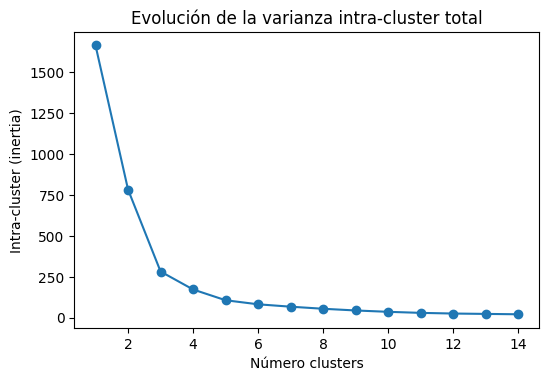

In [58]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(X_ohe_pca)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

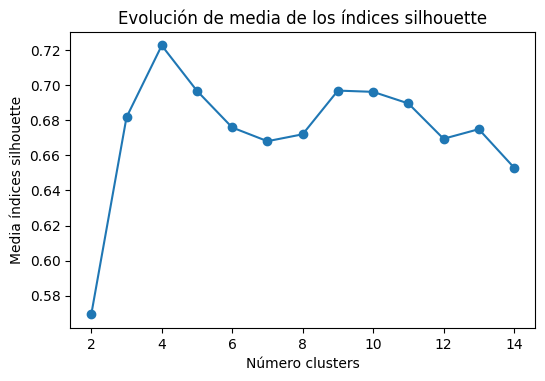

In [59]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_ohe_pca)
    silhouette_avg = silhouette_score(X_ohe_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [121]:
modelo_kmeans = KMeans(n_clusters=4, random_state=100454455)
y_predict = modelo_kmeans.fit_predict(X_ohe_pca)

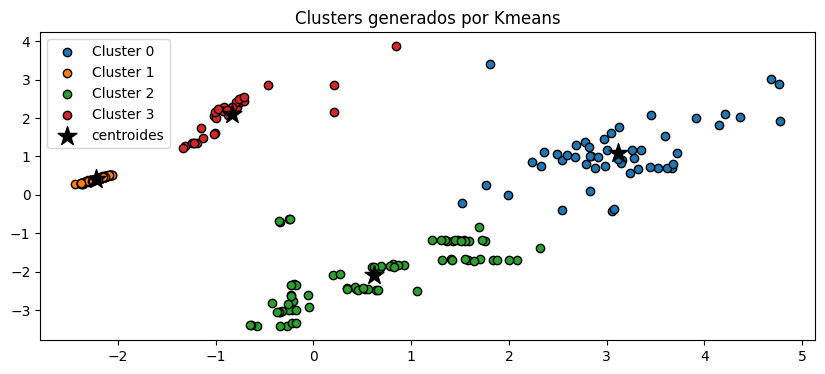

In [122]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 4))


for i in np.unique(y_predict):
    ax.scatter(
        x = X_ohe_pca[y_predict == i, 0],
        y = X_ohe_pca[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

El cambio más significativo es que utilizando OneHotEncoding se obtiene como resultado óptimo una clasificación en 4 clústeres en vez de los 6 que se obtienen utilizando una variable de carácter ordinal. 

In [123]:
cluster_labels = modelo_kmeans.fit_predict(X_ohe_pca)
silhouette_avg = silhouette_score(X_ohe_pca, cluster_labels)
silhouette_avg

0.7222059350391841

In [124]:
kmeans_calinski_harabasz_score = calinski_harabasz_score(X_ohe_pca, y_predict)
kmeans_calinski_harabasz_score

680.4056078555784

Al analizar el coeficiente medio de silueta, así como el coeficiente de Calinski Harabasz para este nuevo modelo, se aprecia una mejora en éstos con respecto al anterior. Sin embargo, esto sucede porque los elementos han cambiado y con estos nuevos datos, aparecen grupos menos dispersos. Pero esto no significa que el modelo sea capaz de hacer mejores predicciones que el anterior. De hecho, este modelo solo es capaz de clasificar los datos en 4 grupos o clústers. Al buscar un modelo de clustering que sea capaz de clasificar en los 6 grupos de estrellas planteados, este modelo estaría detectando 2 grupos menos de los que realmente existen.  

### DBSCAN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


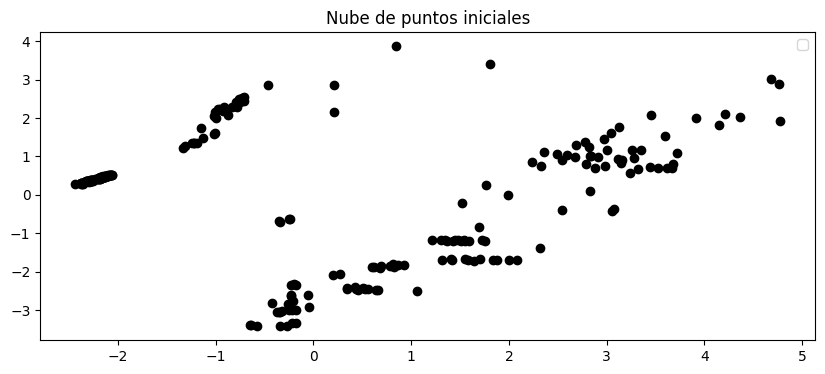

In [62]:
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ohe_pca[:, 0],
    y = X_ohe_pca[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

Volvemos a buscar los valores óptimos para los parámetros eps y min_samples

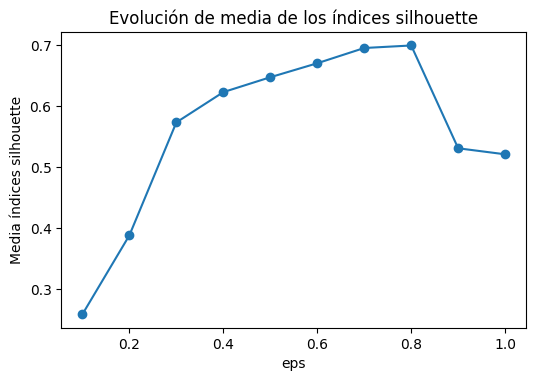

In [105]:
# Método silhouette para identificar el número óptimo de eps
# ==============================================================================
range_eps = np.arange(0.1, 1.1, 0.1)
range_eps = list(range_eps)
valores_medios_silhouette = []

for n_eps in range_eps:
    modelo_dbscan = DBSCAN(
    eps          = n_eps,
    min_samples  = 5,
    metric       = 'euclidean',
    )

    modelo_dbscan.fit(X_ohe_pca)
    cluster_labels = modelo_dbscan.fit_predict(X_ohe_pca)
    silhouette_avg = silhouette_score(X_ohe_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_eps, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('eps')
ax.set_ylabel('Media índices silhouette');

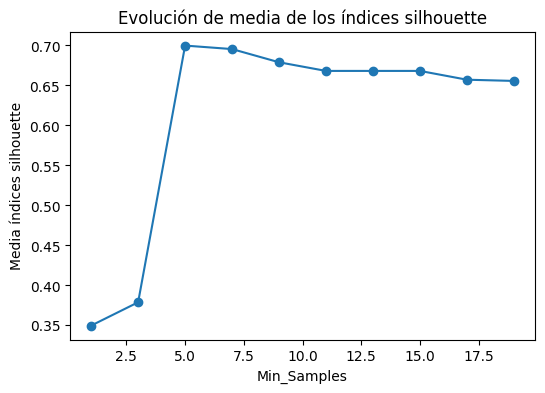

In [106]:
# Método silhouette para identificar el número óptimo de min_samples
# ==============================================================================
range_min_samples = range(1, 20, 2)

valores_medios_silhouette = []

for n_min_samples in range_min_samples:
    modelo_dbscan = DBSCAN(
    eps          = 0.8,
    min_samples  = n_min_samples,
    metric       = 'euclidean',
    )

    modelo_dbscan.fit(X_ohe_pca)
    cluster_labels = modelo_dbscan.fit_predict(X_ohe_pca)
    silhouette_avg = silhouette_score(X_ohe_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range_min_samples, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Min_Samples')
ax.set_ylabel('Media índices silhouette');

In [107]:
modelo_dbscan = DBSCAN(
    eps          = 0.8,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X_ohe_pca)

DBSCAN(eps=0.8)

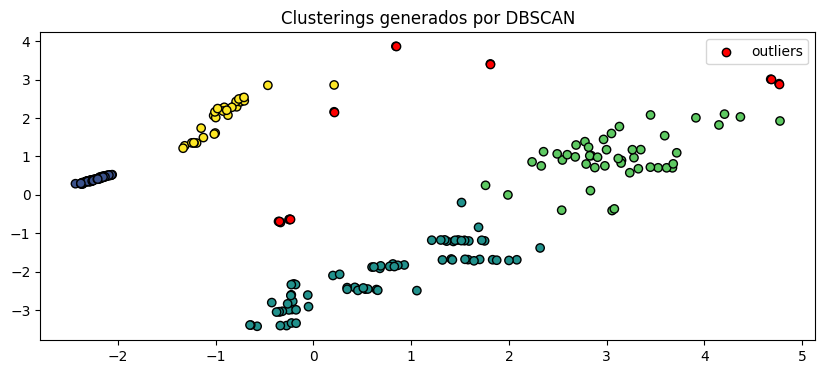

In [108]:
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(
    x = X_ohe_pca[:, 0],
    y = X_ohe_pca[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_ohe_pca[labels == -1, 0],
    y = X_ohe_pca[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [125]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 4
Número de outliers encontrados: 9


Para este modelo, la principal diferencia que se aprecia con respecto al uso de variables ordinales, es que cambia el valor óptimo de eps, subiendo a 0.8, mientras que min_samples queda fijado a 5. En cuanto a los resultados, en este caso hay 9 outliers, menos que en el otro caso. Si analizamos los coeficientes:

In [128]:
cluster_labels = modelo_dbscan.fit_predict(X_ohe_pca)
silhouette_avg = silhouette_score(X_ohe_pca, cluster_labels)
silhouette_avg

0.6997972885071687

In [129]:
labels = modelo_dbscan.labels_
X_sin_outliers = X_ohe_pca[labels != -1]
dbscan_calinski_harabasz_score = calinski_harabasz_score(X_sin_outliers, labels[labels != -1])
dbscan_calinski_harabasz_score

808.2244641809843

Al igual que con kmeans, se ve que ambos coeficientes han mejorado por los mismos motivos. Sin embargo, sigue siendo preferible el uso de una variable ordinaria frente a OneHotEncoding con kmeans. Aunque se obtienen resultados más sólido si, una vez que se usa DBSCAN, se hace con OneHotEncoding. 

## 5. Pipeline

En esta sección se propone un pipeline de clustering completo para abordar el problema de la clasificación de estrellas. Tras el análisis desarrollado en las secciones anteriores, se ha optado por utilizar kmeans con 6 clústers. Para los datos cate